In [2]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE objects
# name of the case; the temporary, remapping and remapped file names include case name
esmr.case_name                = 'North_Asia'              
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
esmr.target_shp               = '/Users/shg096/Desktop/MERIT_Hydro/cat_final/cat_pfaf_35_MERIT_Hydro_v07_Basins_v01_bugfix1_fixed.shp'
esmr.target_shp               = '../data/Source_shp_ERA5/MERIT_NA_test.shp'
# name of netCDF file(s); multiple files can be specified with *
esmr.source_nc                = '../data/Source_nc_ERA5/ERA5_subset_NorthAsia_*.nc'
# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ['airtemp']
# rename the variables from source netCDF file(s) in the remapped files;
# it will be the same as source if not provided
esmr.var_names_remapped       = ['temperature']
# name of variable longitude in source netCDF files
esmr.var_lon                  = 'longitude'
# name of variable latitude in source netCDF files
esmr.var_lat                  = 'latitude'
# name of variable time in source netCDF file; should be always time
esmr.var_time                 = 'time'
# location where the remapped netCDF file will be saved
esmr.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
esmr.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
esmr.fill_value_list          = ['-9999.00']
# if required that the remapped values to be saved as csv as well
#esmr.save_csv                 = True
# if uncommented EASYMORE will use this and skip GIS tasks
esmr.remap_csv                = '../temporary/North_Asia_remapping.csv'

# execute EASYMORE
esmr.nc_remapper()



0.0.2
no author name is provide and the author name is changed to (author name)!
remap file is provided; EASYMORE will use this file and skip calculation of remapping
EASYMORE will remap variable  airtemp  from source file to variable  temperature  in remapped NeCDF file
EASYMORE case exists in the remap file
EASYMORE detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
EASYMORE detects that all the varibales have dimensions of:
['time', 'latitude', 'longitude']
EASYMORE detects that the longitude varibales has dimensions of:
['longitude']
EASYMORE detects that the latitude varibales has dimensions of:
['latitude']
------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping ../data/Source_nc_ERA5/ERA5_subset_NorthAsia_19800101.nc to ../output/North_Asia_remapped_1980-01-01-00-00-00.nc
Started at date and time 2021-08-06 21:32:52.630726
Ended   at date and time 20

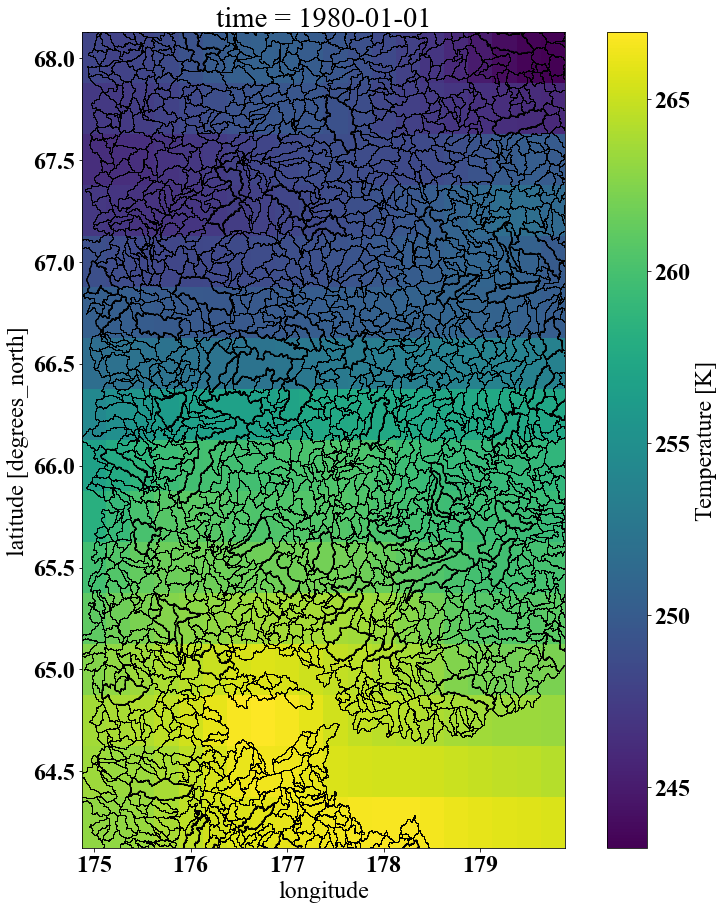

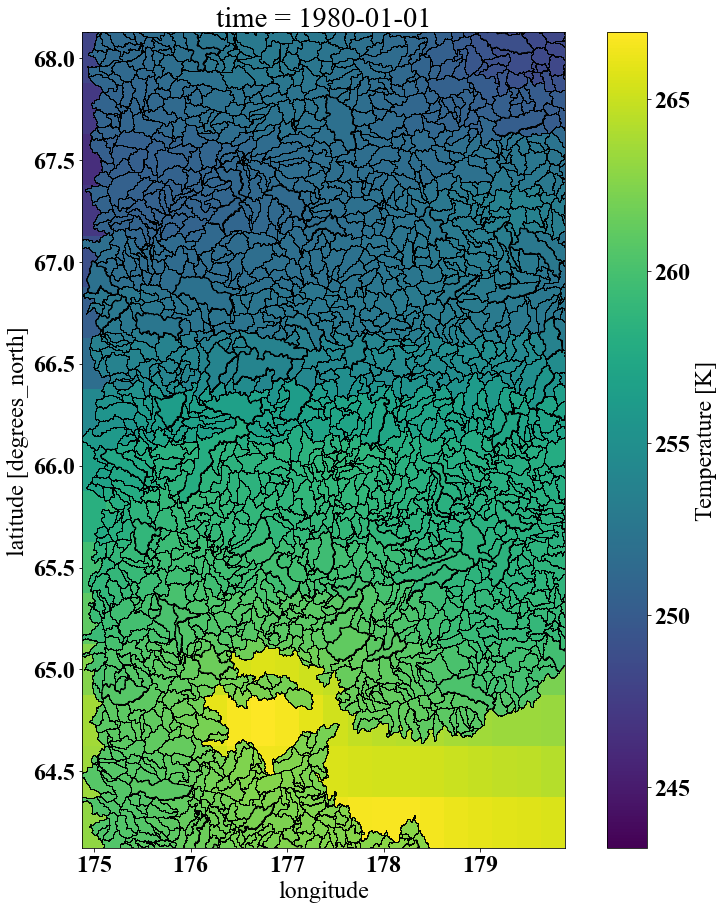

In [7]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

# visualize the original netCDF for the first file, first time step
shp_target = gpd.read_file(esmr.target_shp) # load the target shapefile
# load the first source netcdf file
nc_name = sorted(glob.glob(esmr.source_nc))
ds_source = xr.open_dataset(nc_name[0])
# subset the region of interest:
lat_lim = np.array([   60  ,   75.0 ]) # limit for lat
lon_lim = np.array([  170  ,  190.5 ]) # limit for lon

lat_lim = np.array([   64  ,   68.0 ]) # limit for lat
lon_lim = np.array([  175  ,  180.0 ]) # limit for lon

lats = np.array(ds_source.variables[esmr.var_lat][:] )
lons = np.array(ds_source.variables[esmr.var_lon][:])
lat_low = np.argmin( np.abs( lats - lat_lim[0] ) )
lat_up = np.argmin( np.abs( lats - lat_lim[1] ) )
lon_low = np.argmin( np.abs( lons - lon_lim[0] ) )
lon_up = np.argmin( np.abs( lons - lon_lim[1] ) )
if lat_up < lat_low:
    temp = lat_low
    lat_low = lat_up
    lat_up = temp
if lon_up < lon_low:
    temp = lon_low
    lon_low = lon_up
    lon_up = temp
ds_source = ds_source.isel(latitude=np.arange(lat_low,lat_up))
ds_source = ds_source.isel(longitude=np.arange(lon_low,lon_up))
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
ds_source.airtemp[0,:,:].plot( ax = axes)
shp_target.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1, ax = axes)
plt.savefig('../fig/Example1_A.png')

# visualize the remapped netCDF for the first file, first time step
# target nc file
nc_names = sorted(glob.glob (esmr.output_dir + esmr.case_name + '*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
values   = ds.temperature [0,:] # the first time frame of the first 
IDs      = ds.ID [:] # get the ID
# create a data frame for the model simulation
df = pd.DataFrame()
df ['value'] = values
df ['ID_t']    = IDs  # .astype(int)
df = df.sort_values (by = 'ID_t')
# load the shape file target that is generated by EASYMORE (with consistent IDs)
shp_target = gpd.read_file(esmr.temp_dir+ esmr.case_name + '_target_shapefile.shp') # load the target shapefile
shp_target ['ID_t'] = shp_target ['ID_t'].astype(float)
shp_target = shp_target.sort_values(by='ID_t')# sort on values
shp_target = pd.merge_asof(shp_target, df, on='ID_t', direction='nearest')
shp_target = shp_target.set_geometry('geometry') #bring back the geometry filed; pd to gpd
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
ds_source.airtemp[0,:,:].plot( ax = axes)
ds_source.airtemp[0,:,:].plot( ax = axes, alpha = 1, add_colorbar=False)
shp_target.plot(column= 'value', edgecolor='k',linewidth = 1, ax = axes )#, legend=True)
plt.savefig('../fig/Example1_B.png')



In [1]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

ds = xr.open_dataset('/Users/shg096/Desktop/EASYMORE/data/Source_nc_ERA5/ERA5_subset_NorthAsia_19800101.nc')

print(ds)


<xarray.Dataset>
Dimensions:    (latitude: 146, longitude: 528, time: 24)
Coordinates:
  * longitude  (longitude) float32 58.75 59.0 59.25 59.5 ... 190.0 190.2 190.5
  * latitude   (latitude) float32 81.5 81.25 81.0 80.75 ... 45.75 45.5 45.25
  * time       (time) datetime64[ns] 1980-01-01 ... 1980-01-01T23:00:00
Data variables:
    LWRadAtm   (time, latitude, longitude) float32 ...
    SWRadAtm   (time, latitude, longitude) float32 ...
    pptrate    (time, latitude, longitude) float32 ...
    airpres    (time, latitude, longitude) float32 ...
    airtemp    (time, latitude, longitude) float32 ...
    spechum    (time, latitude, longitude) float32 ...
    windspd    (time, latitude, longitude) float32 ...
Attributes:
    History:                                  Created Mon Jul 19 00:07:20 2021
    Language:                                 Written using Python
    Reason:                                   (1) ERA5 surface and pressure f...
    Conventions (pressure level (10m) data): 

In [1]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

print(esmr.version)

AttributeError: 'easymore' object has no attribute 'version'

In [2]:
print(esmr.)

AttributeError: 'easymore' object has no attribute 'version'

In [4]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()


In [2]:
import geopandas as gpd

shp = gpd.read_file('/Users/shg096/Desktop/MERIT_Hydro/cat_final/cat_pfaf_35_MERIT_Hydro_v07_Basins_v01_bugfix1_fixed.shp')

print(shp)




          COMID   unitarea                                           geometry
0      35000536  34.419508  POLYGON ((138.84375 76.20125, 138.84792 76.201...
1      35000664  26.221470  MULTIPOLYGON (((138.76375 74.73125, 138.76458 ...
2      35002304  35.567927  POLYGON ((132.34958 71.30125, 132.35042 71.301...
3      35016177  62.642259  POLYGON ((172.35458 69.54375, 172.36042 69.543...
4      35008317  47.340852  POLYGON ((138.15708 67.78292, 138.15792 67.782...
...         ...        ...                                                ...
62628  35016181  28.605773  POLYGON ((155.89958 67.60875, 155.90125 67.608...
62629  35016180  57.011621  POLYGON ((156.13875 67.65042, 156.14542 67.650...
62630  35016179   9.637901  POLYGON ((156.30458 67.63042, 156.30875 67.630...
62631  35016178  37.980964  POLYGON ((156.22792 67.69542, 156.22875 67.695...
62632  35007009  53.898509  POLYGON ((156.32708 67.71292, 156.32625 67.712...

[62633 rows x 3 columns]


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


In [3]:

shp ['lat'] = shp.centroid.y
shp ['lon'] = shp.centroid.x


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_11160/2573951026.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp ['lat'] = shp.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_11160/2573951026.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp ['lon'] = shp.centroid.x


In [4]:
print(shp)



          COMID   unitarea                                           geometry  \
0      35000536  34.419508  POLYGON ((138.84375 76.20125, 138.84792 76.201...   
1      35000664  26.221470  MULTIPOLYGON (((138.76375 74.73125, 138.76458 ...   
2      35002304  35.567927  POLYGON ((132.34958 71.30125, 132.35042 71.301...   
3      35016177  62.642259  POLYGON ((172.35458 69.54375, 172.36042 69.543...   
4      35008317  47.340852  POLYGON ((138.15708 67.78292, 138.15792 67.782...   
...         ...        ...                                                ...   
62628  35016181  28.605773  POLYGON ((155.89958 67.60875, 155.90125 67.608...   
62629  35016180  57.011621  POLYGON ((156.13875 67.65042, 156.14542 67.650...   
62630  35016179   9.637901  POLYGON ((156.30458 67.63042, 156.30875 67.630...   
62631  35016178  37.980964  POLYGON ((156.22792 67.69542, 156.22875 67.695...   
62632  35007009  53.898509  POLYGON ((156.32708 67.71292, 156.32625 67.712...   

             lat         lo

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


In [6]:
shp_slice = shp [shp['lon']>175]
shp_slice = shp_slice [shp_slice['lon']<185]
print(shp_slice)


          COMID     unitarea  \
30     35008315    95.341239   
56     35002467    33.625564   
57     35017564    92.107405   
95     35000861  8519.201312   
97     35008288    54.730594   
...         ...          ...   
62305  35007176    16.719596   
62517  35016293    31.169460   
62518  35016292     1.336541   
62519  35016291     0.122750   
62520  35016290    39.953138   

                                                geometry        lat  \
30     MULTIPOLYGON (((179.272 67.840, 179.273 67.840...  67.769618   
56     POLYGON ((175.799 69.551, 175.801 69.551, 175....  69.486300   
57     MULTIPOLYGON (((179.161 66.011, 179.162 66.011...  66.010714   
95     POLYGON ((180.108 71.322, 180.109 71.322, 180....  71.253091   
97     POLYGON ((183.565 67.792, 183.567 67.792, 183....  67.752638   
...                                                  ...        ...   
62305  MULTIPOLYGON (((181.688 67.743, 181.689 67.743...  67.733433   
62517  POLYGON ((181.763 66.070, 181.767 66.070

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


In [7]:
shp_slice.to_file('../data/Source_shp_ERA5/MERIT_NA_test.shp')

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
